In [1]:
import os, subprocess, json, time
from typing import Dict

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

In [2]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
seq_db = os.path.join(base_dir, "input", "sequence_db")

#Path to the benchmark databases
db_len_path = os.path.join(base_dir, "input", "sequence_db", "BM_db_e6")
db_nb_path = os.path.join(base_dir, "input", "sequence_db", "BM_db_100")

out_analysis_path = os.path.join(base_dir, "output", "analysis")

#Path to the modules
db_code = os.path.join(base_dir, "code")

# Benchmark of the detection of HGT by the different metrics

In [3]:
def prepare_HGT_db(input_db : str, output_db : str, iterations : int = 1000, proba : float = 0.05):
    """
    Prepare the artificial database of HGTs
    """
    os.chdir(db_code)
    subprocess.run(
        f"python -m HGTransfer -db {input_db} -o {output_db} -i {iterations} -p {proba}"
        )
    return output_db

def compute_signatures(input_db : str, metric_num : int, metric_name : str):
    """
    Compute the signatures for the database where HGT occured
    """
    os.chdir(db_code)

    subprocess.run(
        f"python -m compute_signatures {input_db} -m {metric_num}"
        )
    return f"{input_db}_{metric_name}.json"

def backtrack_analysis(output_db : str, json_file : str, eval_file : str):
    """
    Compute the backtrack analysis for detected HGTs into the database.
    """
    os.chdir(db_code)

    subprocess.run(
        f"python -m analysis {json_file} {output_db} -r {eval_file}"
    )
    return 0

In [4]:
def load_summaries(output_db, ref_file : str, json_file : str):
    """
    Load files for evaluation.
    """
    json_path = os.path.join(base_dir, "output", "transfer_summary", json_file)
    with open(json_path, 'r', encoding='utf-8') as jfile :
        json_raw = json.load(jfile)

    ref_path = os.path.join(seq_db, output_db, ref_file)

    with open(ref_path, 'r') as ref_raw :
        ref_raw = ref_raw.readlines()
    
    ref_dico = {}
    for ref in ref_raw[1:]:
        sending, sd_start, sd_end, receiving, rc_pos = ref.split('\t\t')
        ref_dico[receiving] = int(rc_pos.strip())
    return json_raw, ref_dico


def eval(json_raw : Dict[str, Dict[int, float]], ref_dico : Dict[str, int], window : int = 10000):
    """
    Check how many generated HGT are caught.
    """
    count = 0
    for receiver, position in ref_dico.items():
        if json_raw[receiver]:
            pass
        else:
            continue

        if any((position > int(loc)-2*window and position < int(loc)+2*window) for loc, intensity in json_raw[receiver].items()):
            count += 1
    
    return count

def get_backtrack_results(eval_report_path : str, path_db_report : str):
    with open(eval_report_path, 'r') as eval_report:
        report = len(eval_report.readlines())
    
    with open(path_db_report, 'r') as generator_report:
        generator_size = len(generator_report.readlines())
    return report, generator_size

        
def benchmark_HGT_detection(input_db : str, output_db : str):
    couples_metric = { 
        "L2_distance" : 0,
        "Chi-squared_distance" : 1,
        "KL_divergence" : 2,
        "average_frequency" : 3
    }
    results_metric = {metric : {"Accuracy score" : 0, "Hit ratio" : 0} for metric in couples_metric.keys()}
    stats_metric = {metric : {"TP" : 0, "FN":0, "Time (s)" : 0} for metric in couples_metric.keys()}

    output_db = prepare_HGT_db(input_db, output_db, proba=0.005)
    gen_db_report = os.path.join(seq_db, output_db, "HGT_report.txt")

    for metric_name, num_metric in couples_metric.items():
        json_summary = compute_signatures(output_db, metric_name=metric_name, metric_num=num_metric)
        json_raw, ref_dico = load_summaries(output_db, "HGT_report.txt", json_summary)
        
        avg_finding = sum([len(summary) for summary in json_raw.values()])/len(json_summary)
        print(avg_finding)
        
        found_HGT = eval(json_raw, ref_dico)
        results_metric[metric_name]["Accuracy score"] = found_HGT/len(ref_dico) # accuracy respect to artificial HGT
        results_metric[metric_name]["Hit ratio"] = found_HGT/avg_finding

        st = time.time()
        backtrack_analysis(output_db, json_summary, gen_db_report)

        eval_report_path = os.path.join(out_analysis_path, "eval_analysis_report.txt")
        tp, tot_HGT = get_backtrack_results(eval_report_path, gen_db_report)
        fn = tot_HGT-tp

        stats_metric[metric_name]["TP"] = tp
        stats_metric[metric_name]["FN"] = fn
        stats_metric[metric_name]['Time (s)'] = round(time.time()-st, 4)

        print(metric_name, results_metric,stats_metric, sep='\n')
    
    return pd.DataFrame(data=results_metric), pd.DataFrame(data=stats_metric)
    
result_df, stats_df = benchmark_HGT_detection("Brinkman", "generator_db")

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable: 'c:\\Subpbiotech_cours\\BT5\\BIM_BMC\\GENOM\\project\\project_git\\GENOM\\Benchmark\\code'

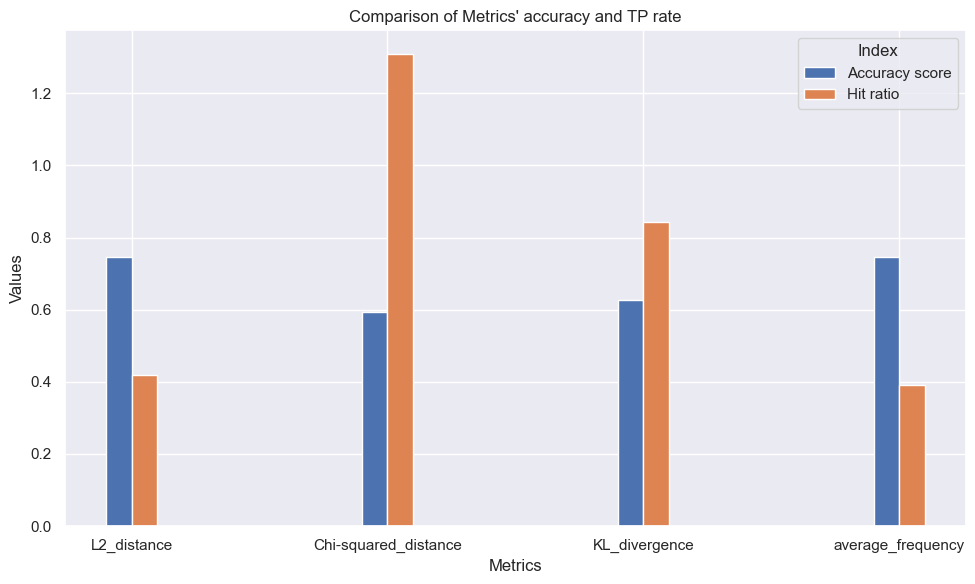

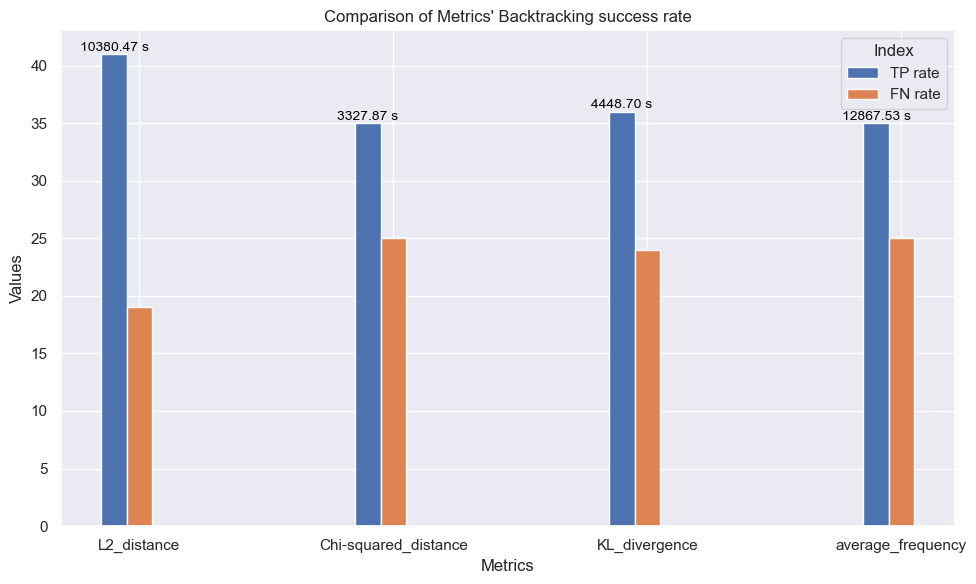

In [8]:
def show_results(result_df: pd.DataFrame, job : str):
    bar_width = 0.1  
    indices = np.arange(len(result_df.columns))  
    index_labels = result_df.index  

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, index in enumerate(result_df.index):
        if index == "Time (s)":
            break
        ax.bar(indices + i * bar_width, result_df.loc[index], bar_width, label=index)

    if "Time (s)" in result_df.index:
        for i, col in enumerate(result_df.columns):
            tp, fn, time = result_df[col].values

            max_value = np.array([tp, fn]).max()
            max_index = np.array([tp, fn]).argmax()
            ax.text(
                indices[i] + max_index *bar_width,  
                max_value + 0.01,                    # Y-coordinate (slightly above the bar)
                f"{time:.2f} s",                 # Text to display (rounded to 2 decimal places)
                ha="center",                        # Center alignment
                va="bottom",                        # Bottom alignment
                fontsize=10,                        # Font size
                color="black",                 # Text color
            )

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(f"Comparison of Metrics' {job}")
    ax.set_xticks(indices + bar_width * (len(index_labels) - 1) / 2)
    ax.set_xticklabels(result_df.columns)
    ax.legend(title="Index")

    plt.tight_layout()
    plt.show()


show_results(result_df, "accuracy and TP rate")
show_results(stats_df, "Backtracking success rate")

In [9]:
stats_df

,L2_distance,Chi-squared_distance,KL_divergence,average_frequency
TP rate,41.0000,35.0000,36.0000,35.0000
FN rate,19.0000,25.0000,24.0000,25.0000
Time (s),10380.4673,3327.8673,4448.7021,12867.5305


In [10]:
result_df

,L2_distance,Chi-squared_distance,KL_divergence,average_frequency
Accuracy score,0.745763,0.593220,0.627119,0.745763
Hit ratio,0.419048,1.309055,0.842144,0.392157


In [ ]:
print(len(avg_finding))